First we load in the loneliness data, a loneliness score is given for each MSOA (Middle Layer Super Output Area). Since we plan to compare to Ofsted school data which is given for local authorities we combine MSOAs

In [9]:
#This dataset file is also needed https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-february-2022-lookup-in-the-uk/about

import pandas as pd

loneliness_data = pd.read_csv("msoa_loneliness.csv")
msoa_la_code_df = pd.read_csv('PCD_OA_LSOA_MSOA_LAD_FEB22_UK_LU.csv', encoding='latin-1') #change encoding to fix read error
#get LA code from msoa code
msoa_code_rows = msoa_la_code_df.loc[msoa_la_code_df['msoa11cd'].isin(loneliness_data['msoa11cd'])]
msoa_code_conv = dict(zip(msoa_code_rows['msoa11cd'],msoa_code_rows['ladcd']))
loneliness_data['LA code'] = loneliness_data['msoa11cd'].apply(lambda x: msoa_code_conv[x])
#print(loneliness_data)

LA_counts = loneliness_data.groupby('LA code').count()
LA_index_sum = loneliness_data.groupby('LA code').sum()['loneills_2018']
LA_index_average = LA_index_sum / LA_counts['msoa11cd']


# 1st attempted to merge by name - better to use LA codes

#perform the grouping by the local authority names of the msoas
# loneliness_data['msoa11nm']  = loneliness_data['msoa11nm'].str[:-4] # Strip numbers off names
# LA_counts = loneliness_data.groupby('msoa11nm').count()
# LA_index_sum = loneliness_data.groupby('msoa11nm').sum()['loneills_2018']
# LA_index_average = LA_index_sum / LA_counts['msoa11cd']

lonely_index_average = LA_index_average.rename('lonely_avg').to_frame()
print(lonely_index_average)# loneliness index average for each LA



C:\Users\Jonathan\AppData\Local\Temp/ipykernel_29532/4059878155.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  msoa_la_code_df = pd.read_csv('PCD_OA_LSOA_MSOA_LAD_FEB22_UK_LU.csv', encoding='latin-1') #change encoding to fix read error


           lonely_avg
LA code              
E06000001   -0.542761
E06000002    1.316155
E06000003    0.649266
E06000004    0.635474
E06000005    0.967079
...               ...
E09000029    0.922554
E09000030   -1.569304
E09000031   -0.738428
E09000032    0.855884
E09000033    0.243843

[309 rows x 1 columns]


We now get migration data for each local authority, we will sum migration in and out as both represent changes in people living in the area. We note the migration data is estimated by the ONS.

In [10]:
migration_data = pd.read_excel('laandregionssex5age2018newboundaries.xlsx', sheet_name=3, header=6)
print(migration_data.head(5))
# use ages 5-9 and 10-14 for school data 
ages = ['5-9','10-14']
#Inflow.1 is male, Inflow.2 is female
migration_school_ages = migration_data[migration_data['Age'].isin(ages)]
migration_school_ages = migration_school_ages.groupby('LA code').sum()
migration_school_ages['TotalFlow'] = migration_school_ages['Inflow'] + migration_school_ages['Outflow']
print(migration_school_ages.head(5))


     LA code     LA name    Age  Inflow  Outflow  Net  Inflow.1  Outflow.1  \
0  E06000001  Hartlepool    0-4     179      188   -9        92         86   
1  E06000001  Hartlepool    5-9     189      134   55        96         77   
2  E06000001  Hartlepool  10-14     124      147  -23        57         77   
3  E06000001  Hartlepool  15-19     153      380 -227        57        167   
4  E06000001  Hartlepool  20-24     518      475   43       228        217   

   Net.1  Inflow.2  Outflow.2  Net.2  
0      6        87        102    -15  
1     19        93         57     36  
2    -20        67         70     -3  
3   -110        96        213   -117  
4     11       290        258     32  
           Inflow  Outflow  Net  Inflow.1  Outflow.1  Net.1  Inflow.2  \
LA code                                                                 
E06000001     313      281   32       153        154     -1       160   
E06000002     544      734 -190       294        366    -72       250   
E0600

In [11]:
#get the school data
ofsted_df = pd.read_csv('OFSTED\england_school_information.csv',header=0)
#remove international schools (overseas territories)
ofsted_df = ofsted_df.loc[ofsted_df['LA'] != 704]
ofsted_df = ofsted_df.loc[ofsted_df['LA'] != 702]

area_conversion = pd.read_excel('nlac-2011.xls',header=0)
old2newLA = dict(zip(area_conversion['Old LA Code'],area_conversion['LA Name']))
#Fix changes to LA codes since 2011
old2newLA[838] = 'Dorset'
old2newLA[839] = 'Bournemouth, Christchurch & Poole'
old2newLA[941] = 'West Northamptonshire'
old2newLA[940] = 'North Northamptonshire'
ofsted_df['LA name']  = ofsted_df['LA'].apply(lambda x : old2newLA[x])

old2newLAcode = dict(zip(area_conversion['Old LA Code'],area_conversion['New LA Code']))
#Fix changes to LA codes since 2011
old2newLAcode[838] = 'E06000059'
old2newLAcode[839] = 'E06000058'
old2newLAcode[941] = 'E10000021'
old2newLAcode[940] = 'E10000021'
ofsted_df['New LA']  = ofsted_df['LA'].apply(lambda x : old2newLAcode[x])

#remove schools without ofsted rating
ofsted_df = ofsted_df.loc[ofsted_df['OFSTEDRATING'] != '']
ofsted_df = ofsted_df.loc[ofsted_df['OFSTEDRATING'].notna()]
ofsted_df = ofsted_df.loc[ofsted_df['OFSTEDRATING'] != 'Insufficient evidence']

rating_conversion = {'Outstanding' : 4, 'Good' : 3,'Requires improvement': 2, 'Inadequate' : 1, 'Serious Weaknesses': 1, 'Special Measures': 1}
ofsted_df['OFSTEDRATING'] = ofsted_df['OFSTEDRATING'].apply(lambda x: rating_conversion[x])
ofsted_sum = ofsted_df.groupby('New LA').sum()
ofsted_count = ofsted_df.groupby('New LA').count()

ofsted_avg = (ofsted_sum['OFSTEDRATING'] / ofsted_count['LA']).rename('Ofsted Avg').to_frame()
#print(migration_school_ages['LA code'])
print(ofsted_avg.head())

           Ofsted Avg
New LA               
E06000001    3.000000
E06000002    2.955556
E06000003    2.791667
E06000004    3.085714
E06000005    2.894737


In [24]:
#Get LA population data 
pop_df = pd.read_excel('ukmidyearestimates20182019ladcodes.xls',sheet_name='MYE2-All',header=4)
pop_df = pop_df.loc[pop_df['Code'].isin(lonely_index_average.reset_index()['LA code'])]
pop_dict = dict(zip(pop_df['Code'],pop_df['All ages']))

In [13]:
#Income data for uk regions - gross disposable household income (GDHI) per head as index 
income_df = pd.read_excel('regionalgrossdisposablehouseholdincomeallitlregions.xls',sheet_name='Table 3',header= 1)
itl_coversion_df = pd.read_excel('LAD21_LAU121_ITL321_ITL221_ITL121_UK_LU.xlsx',header=0)
income_df = income_df.loc[income_df['ITL code'].str.len() == 5] #filter to smaller regions
itl2LAcode = dict(zip(itl_coversion_df['ITL321CD'],itl_coversion_df['LAD21CD']))
income_df['LA code'] = income_df['ITL code'].apply(lambda x: itl2LAcode[x])
income_df = income_df[['LA code',2018]]
income_df = income_df.rename(columns={2018:'GDHI income index'})
income_df

,LA code,GDHI income index
4,E06000004,79.3
5,E06000003,76.2
6,E06000005,82.8
7,E06000047,78.0
9,E06000057,94.9
...,...,...
229,N09000004,80.4
230,N09000001,82.8
231,N09000007,92.8
232,N09000008,85.9


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_29532/3622726234.py:4: DtypeWarning: Columns (1,2,3,4,11,14,16,18,22,23,24,27,28,31,32,34,36,38,40,42,44,46,65,69,73,100,101,102,103,104,105,109,110,111,112,113,114,122,123,124,125,126,127,128,129,130,131,132,133,137,138,139,140,141,142,150,151,152,153,154,155,156,157,158,159,160,161,165,166,167,168,169,170,178,179,180,181,182,183,184,185,187,188,191,192,193,194,196,197,200,201,202,203,205,206,209,210,251,253,270,271,272,273,274,275,276,277,278,279,280,290,291,292,293,294,295,296,297,298,299,300,304,305,306,307,308) have mixed types. Specify dtype option on import or set low_memory=False.
  ks2_df = pd.read_csv('OFSTED\england_ks2final.csv', header= 0)
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_29532/3622726234.py:5: DtypeWarning: Columns (53,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  ks4_df = pd.read_csv('OFSTED\england_ks4final.csv', header= 0)


Shape:  (149, 294)
[0.99396079]
                                0
DIFFN_RWM_EXP           -0.000060
READPROG_L_UPPER        -0.000017
MATPROG_FSM6CLA1A_UPPER -0.000015
MATPROG_L_UPPER         -0.000015
READPROG_EAL_UPPER      -0.000014
...                           ...
TEALGRP1                 0.116308
TMOBN                    0.128050
TELIG                    0.137473
TPUPYEAR                 0.138009
TOTPUPS                  0.950276

[240 rows x 1 columns]
           KS2 metrics PCA
LA code                   
E09000007    -20507.204753
E09000011     -3456.114929
E09000012    -11583.669126
E09000013    -20438.404579
E09000019    -15365.078970
...                    ...
E10000027      7899.234622
E10000029     28634.291312
E10000030     52186.307003
E10000031     12508.719439
E10000032     33656.466658

[149 rows x 1 columns]


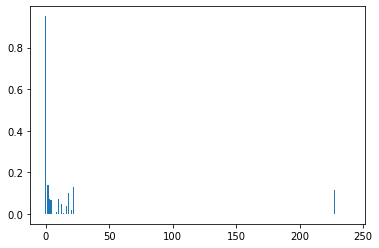

In [14]:
#KS2 school data
import numpy as np
import matplotlib.pyplot as plt
ks2_df = pd.read_csv('OFSTED\england_ks2final.csv', header= 0)
ks4_df = pd.read_csv('OFSTED\england_ks4final.csv', header= 0)
ks2_df = ks2_df[16356:] # Just take the LA data at the bottom 
ks2_df = ks2_df.loc[ks2_df['LEA'] != ' '] # remove rows without LEA codes
ks2_df = ks2_df.loc[ks2_df['LEA'] != '420'] # remove isles of scilly
ks2_df['LA code'] = ks2_df['LEA'].apply(lambda x: old2newLAcode[int(x)]) # Convert old LEA to new LA codes
#print(ks2_df.head())
ks2_df = ks2_df.set_index('LA code')
ks2_df = ks2_df.drop(columns=['RECTYPE','ALPHAIND','LEA',	'ESTAB','URN','SCHNAME','ADDRESS1',	'ADDRESS2',
	'ADDRESS3',	'TOWN','PCODE','TELNUM','PCON_CODE','PCON_NAME','URN_AC','SCHNAME_AC','OPEN_AC',
    'NFTYPE','ICLOSE','RELDENOM','AGERANGE','CONFEXAM',	'TAB15','TAB1618'])

ks2_df = ks2_df.applymap(lambda x: float(x.strip('%'))/100 if str(x).endswith('%') else x) #transform values like '17%' to 0.17
ks2_df = ks2_df.applymap(lambda x: float(x.strip('%'))/100 if str(x).endswith('%') else x) #transform values like '17%' to 0.17
print('Shape: ',ks2_df.shape)
ks2_df = ks2_df.applymap(lambda x: np.nan if x == '' or x == ' ' else x)
ks2_df.dropna(axis=1, how='any',inplace=True)
#Perform PCA on the school metrics
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(ks2_df)
print(pca.explained_variance_ratio_) # PC 1 has 0.99 of the variance
pc_weights = pd.DataFrame(pca.components_[0],ks2_df.keys())
print(pc_weights.sort_values(0))
plt.bar(range(len(pca.components_[0])),pca.components_[0])
ks2_pca_df  = pd.DataFrame(pca.transform(ks2_df), index=ks2_df.index).rename({0:'KS2 metrics PCA'},axis=1)
print(ks2_pca_df)

     index    LA code  Inflow  Outflow     Net  Inflow.1  Outflow.1  Net.1  \
0        0  E06000001   313.0    281.0    32.0     153.0      154.0   -1.0   
1        1  E06000002   544.0    734.0  -190.0     294.0      366.0  -72.0   
2        2  E06000003   512.0    387.0   125.0     242.0      202.0   40.0   
3        3  E06000004   706.0    578.0   128.0     373.0      291.0   82.0   
4        4  E06000005   399.0    366.0    33.0     202.0      192.0   10.0   
..     ...        ...     ...      ...     ...       ...        ...    ...   
312    312  E09000029  1151.0   1086.0    65.0     609.0      565.0   44.0   
313    313  E09000030   773.0   1170.0  -397.0     401.0      618.0 -217.0   
314    314  E09000031  1156.0   2386.0 -1230.0     577.0     1245.0 -668.0   
315    315  E09000032   865.0   1878.0 -1013.0     474.0      983.0 -509.0   
316    316  E09000033   602.0   1209.0  -607.0     313.0      612.0 -299.0   

     Inflow.2  Outflow.2  Net.2  TotalFlow  Ofsted Avg  lonely_

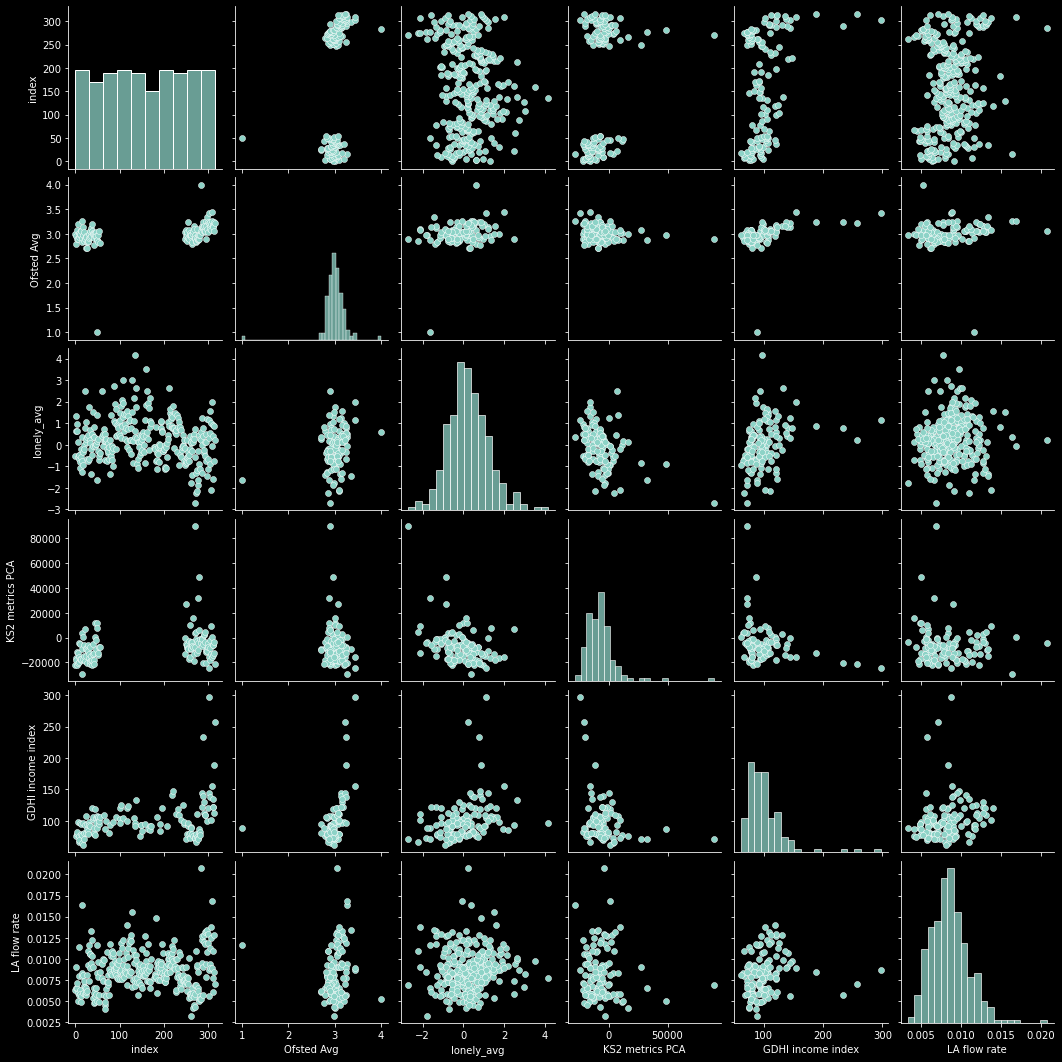

In [30]:
import scipy

LAcodes_df = pd.read_csv('Local_Authority_Districts__December_2020__Names_and_Codes_in_the_United_Kingdom.csv',header=0)
LAcode2name = dict(zip(LAcodes_df['LAD20CD'],LAcodes_df['LAD20NM']))
#Add back abolished LAs
LAcode2name['E07000004'] = 'Aylesbury Vale'
LAcode2name['E07000005'] = 'Chiltern'
LAcode2name['E07000006'] = 'South Bucks'
LAcode2name['E07000007'] = 'Wycombe'

# Join the loneliness index with the migration data
main_df = migration_school_ages.join(ofsted_avg,on= 'LA code')
main_df = main_df.join(lonely_index_average, on='LA code')
main_df = pd.merge(main_df,ks2_pca_df,on='LA code',how='outer') #Missing some regions
main_df = pd.merge(main_df,income_df,on='LA code', how='outer') #Missing some regions

main_df = main_df.reset_index()

#main_df = main_df.loc[main_df['Ofsted Avg'].notna()] # remove LAs from wales etc which we havent calcualted Ofsted or lonely avg
main_df = main_df.loc[main_df['lonely_avg'].notna()]
print(main_df)

main_df['LA name'] = main_df['LA code'].apply(lambda x: LAcode2name[x])
main_df['LA flow rate'] =  main_df['TotalFlow'] / main_df['LA code'].apply(lambda x: pop_dict[x])

# main_df['KS2_PCA_Zscore'] = scipy.stats.zscore(main_df['KS2 metrics PCA'])
# main_df = main_df.loc[main_df['KS2_PCA_Zscore'].abs() <=3]


# main_data['lonely_avg'] = pd.to_numeric(main_data['lonely_avg'])
main_vars = main_df.drop(columns=['Net', 'Inflow.1', 'Outflow.1', 'Net.1', 'Inflow.2','Outflow.2','Net.2'])
main_vars = main_vars.drop(columns=['Inflow', 'Outflow','TotalFlow'])
print(main_vars.head(4))
print(main_vars.corr())

import seaborn as sns
import matplotlib
matplotlib.style.use('dark_background')
sns.pairplot(main_vars)

We can see there is a negative correlation between average loneliness and total migration flow of school age people.
There is a positive correlation between avg ofsted rating and total migration flow 
Perhaps higher total flow seems to coincide with lower loneliness index

In [31]:
main_vars.drop(columns=['index'],inplace=True)
print(main_vars.head())
main_vars.to_csv('SchoolRankingIncome.csv',index=False)

     LA code  Ofsted Avg  lonely_avg  KS2 metrics PCA  GDHI income index  \
0  E06000001    3.000000   -0.542761    -22376.054139                NaN   
1  E06000002    2.955556    1.316155    -16308.990169                NaN   
2  E06000003    2.791667    0.649266    -18159.719122               76.2   
3  E06000004    3.085714    0.635474    -11390.336475               79.3   
4  E06000005    2.894737    0.967079    -22128.626436               82.8   

                LA name  LA flow rate  
0            Hartlepool      0.006371  
1         Middlesbrough      0.009093  
2  Redcar and Cleveland      0.006576  
3      Stockton-on-Tees      0.006511  
4            Darlington      0.007179  
